<p align="center">
<img src="https://github.com/Lwhieldon/OnlineRetailCustomerSegmentation/blob/main/images/Customer-segmentation-performance-matrix.png?raw=true"  style="width: 800px;"  />
</p>

## Overview & Background
Customer retention & engagement is key in all business ventures. But in online retail, it is critical! In this repo, I pretend that I am a data scientist hired by <b>Giftware Shop</b>'s marketing team to analyze & understand customer insights that will help enhance their marketing campaigns. The marketing team wants to increase website traffic and therefore purchases made on the online retail site.
<br>
<br>
We understand that Giftware Shop is an online retailer located in the United Kingdom. They mainly sell "unique" gifts for all occasions: Birthdays, Holidays, etc. The data provided by Giftware Shop's marketing team consists of online retail data describing the transactions and customers tagged to every customer. Their marketing team has tasked me with identifying overall customer segments and behaviors that these groups share so that the marketing team can tailor campaigns to these customers.

## Data Preparation

Let's cleaning & aggregate data to ensure that the data provided does not contain any nulls or outliers before adding to unsupervised learning models. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import seaborn as sns

In [2]:
os.chdir(r'C:\Users\lwhieldon\OneDrive - SC&H Group\Administrative\School Materials\DATA 602 - Into to Data Analysis and ML\OnlineRetailCustomerSegmentation\images')


In [3]:
dataset = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

In [4]:
df_initial = pd.read_excel(dataset,encoding="ISO-8859-1",converters={'CustomerID':str,'InvoiceNo':str})
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df_initial.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


For the purpose of this exercise, let's first check to see if invoices beginning with 'c' (i.e. cancelled purchases) are in the dataset. Giftware shop is interested in determining customer segmentation based on customers who purchased products, not cancelled purchases, so we can remove all cancelled purchases from the dataset.

Let's also remove null records, especially where a customer id is not assigned.

In [7]:
df_initial = df_initial[~df_initial.InvoiceNo.str.startswith('C', na=False)]

In [8]:
df_initial.isnull().sum()
#Description & Customer ID contain null records.

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
dtype: int64

In [9]:
missing_customerIDs = df_initial['CustomerID'].isnull().sum()/df_initial['CustomerID'].count()

print('Percentage of Customer IDs missing is {:0%}'.format(missing_customerIDs))

Percentage of Customer IDs missing is 33.849931%


Since ~34% of the records are missing and still leaves us with a good portion of data, let's remove these records for now.

Now we are left data with no nulls and better data to use in the clustering algorithms

In [10]:
df_initial.dropna(inplace=True)
df_initial.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
#Add a new Total Invoice Amt Column
df_initial['Total Line Amount']= df_initial['Quantity'] * df_initial['UnitPrice']

In [12]:
# Add a Day of Week Purchase Column
df_initial['PurchaseDayofWeek'] = pd.to_datetime(df_initial['InvoiceDate']).dt.dayofweek
df_initial['PurchaseDayofWeek'].unique()

array([2, 3, 4, 6, 0, 1], dtype=int64)

In [13]:
# Add a Time of Day Purchase Column
df_initial['PurchaseTimeofDay'] = pd.to_datetime(df_initial['InvoiceDate'],format='%H:%m').dt.hour
df_initial['PurchaseTimeofDay'].unique()

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17,  7, 18, 19, 20,  6],
      dtype=int64)

In [14]:
#Add a Date Only Column from Invoice Date (no timestamp)
df_initial['InvoiceDate_noTime'] = pd.to_datetime(df_initial['InvoiceDate']).dt.date

In [15]:
print('Total no. of customers: ',df_initial['CustomerID'].nunique())
print('Total transactions : ',df_initial['InvoiceNo'].nunique())
print('Products sold are : ',df_initial['StockCode'].nunique())

Total no. of customers:  4339
Total transactions :  18536
Products sold are :  3665


Over 4k customers to use. Perfect! This should really support solid models with the number of customers in the dataset. There's plenty of transactions & products to better understand customers too

In [16]:
df_initial.reset_index(drop=True, inplace=True)

## Feature Engineering

Since we are looking at the data on a customer level, let's aggregate & perform feature engineering on the dataset. We will create the following features:

1. Total Purchase Amount by Customer 
1. Total Number of Transactons by Customer
1. Distinct Products Types Purchased by Customer
1. Tenure (in days) of being a customer (based on last transaction in the dataset)
1. Apply getdummies to country feature; 1 = UK, 0 = Non-UK
1. Customers who, on average, purchase more products during the business week (Monday - Friday). Will denote with 1
1. Customers who, on average, purchase more products during normal business hours (To keep our analysis consistent, let's assume the dates and times are collected in British time; therefore, we will check to see times between 9a-5pm British time). Also, we will also factor in when a customer calls during the weekend as I want to make this indicator mutually exclusive from the workweek attribute above. Will denote with 1

Once we have aggregated our measures, let's create a new dataframe that groups all features by customer 

Lastly, we will apply standard scaler to our continuous features before we fit them to the models.


In [17]:
#Total Purchase Amount by Customer
total_amount = df_initial['Total Line Amount'].groupby(df_initial['CustomerID']).sum().reset_index()\
        .rename(columns={"Total Line Amount": "TotlAmtbyCust"})

In [18]:
#Number of Transactions by Customer
transactions = df_initial['InvoiceNo'].groupby(df_initial['CustomerID']).count().reset_index()\
        .rename(columns={"InvoiceNo": "TotalCustTransactions"})

In [19]:
#Distinct Products Types Purchased by Customer
product_types = df_initial['StockCode'].groupby(df_initial['CustomerID']).nunique().reset_index()\
                .rename(columns={"StockCode":"DistProductsbyCust"})

In [20]:
#Tenure (in days) of being a customer (based on last transaction in the dataset)
final = df_initial['InvoiceDate_noTime'].max()
df_initial['TenureofCustomer'] = final - df_initial['InvoiceDate_noTime']
CustomerTenure = df_initial['TenureofCustomer'].groupby(df_initial['CustomerID']).min().dt.days    

In [21]:
df_initial['Country'].value_counts()
#Biggest customer is from the UK.

United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

Since a good portion of the online retailer's customers are from the UK, let's create a new feature where we assign a customer from the UK with 1 and everyone else 0

In [22]:
#Apply getdummies to country feature
Countries = pd.concat([df_initial['CustomerID'],pd.get_dummies(df_initial['Country']=='United Kingdom', prefix='IsUK')],1)
Countries = Countries.loc[1:].groupby(Countries['CustomerID']).max()
Countries = pd.DataFrame(Countries).reset_index(drop=True)
Countries.drop('IsUK_False',axis='columns', inplace=True)
Countries=Countries.rename(columns={'IsUK_True':'IsUK'})

In [23]:
# Customers who, on average, purchase more products during the business week (Monday - Friday). Will denote with 1
IsWeekday = pd.concat([df_initial['CustomerID'].groupby(df_initial['CustomerID'])\
                       .max(),round(df_initial['PurchaseDayofWeek'].groupby(df_initial['CustomerID']).sum()\
                                    /df_initial['PurchaseDayofWeek'].groupby(df_initial['CustomerID']).count())],1)
IsWeekday = pd.DataFrame(IsWeekday).reset_index(drop=True)
IsWeekday['IsWeekDay'] = (IsWeekday['PurchaseDayofWeek']==0) & (IsWeekday['PurchaseDayofWeek']==6).any()
IsWeekday['IsWeekDay']=pd.get_dummies(IsWeekday['IsWeekDay'])
IsWeekday.drop('PurchaseDayofWeek',axis='columns', inplace=True)


In [24]:
# Customers who, on average, purchase more products during normal business hours (9a-5pm British time). Will denote with 1
IsWorkDay = pd.concat([df_initial['CustomerID'].groupby(df_initial['CustomerID'])\
                       .max(),round(df_initial['PurchaseTimeofDay'].groupby(df_initial['CustomerID']).sum()\
                                    /df_initial['PurchaseTimeofDay'].groupby(df_initial['CustomerID']).count())],1)
IsWorkDay = pd.DataFrame(IsWorkDay).reset_index(drop=True)

IsWorkDay['IsWorkDay'] = np.where((IsWorkDay['PurchaseTimeofDay']>= 9) & (IsWorkDay['PurchaseTimeofDay']<= 14), False, True)
IsWorkDay['IsWorkDay']=pd.get_dummies(IsWorkDay['IsWorkDay'])
IsWorkDay.drop('PurchaseTimeofDay',axis='columns', inplace=True)

In [25]:
df_new = pd.merge(total_amount,transactions,how='inner',on='CustomerID')
df_new = pd.merge(df_new,product_types,how='inner',on='CustomerID')
df_new = pd.merge(df_new,CustomerTenure,how='inner',on='CustomerID')
df_new = pd.merge(df_new,Countries,how='inner',on='CustomerID')
df_new = pd.merge(df_new,IsWeekday,how='inner',on='CustomerID')
df_new = pd.merge(df_new,IsWorkDay,how='inner',on='CustomerID')
df_new.drop('CustomerID',axis='columns', inplace=True)

Text(0.5, 0, 'Attributes')

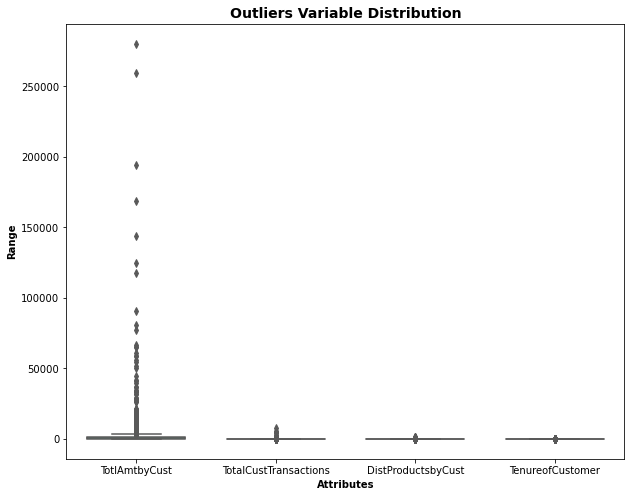

In [26]:
# Outlier Analysis of Amount #ofTransactions, and Disinct Products & Tenure

attributes = ['TotlAmtbyCust','TotalCustTransactions','DistProductsbyCust','TenureofCustomer']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_new[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

Whoa! BIG outliers in TotlAmtbyCust; this could throw off our model. Let's reduce the dataset to only include prices & customer transactions that fall with the 95% percentile to help reduce the <b>outliers</b>. 

In [27]:
q_low = df_new["TotlAmtbyCust"].quantile(0.04)
q_hi  = df_new["TotlAmtbyCust"].quantile(0.95)
df_new = df_new[(df_new["TotlAmtbyCust"] < q_hi) & (df_new["TotlAmtbyCust"] > q_low)]
q_low = df_new["TotalCustTransactions"].quantile(0.04)
q_hi  = df_new["TotalCustTransactions"].quantile(0.95)
df_new = df_new[(df_new["TotalCustTransactions"] < q_hi) & (df_new["TotalCustTransactions"] > q_low)]
df_new.reset_index(drop=True, inplace=True)
df_new.describe()


,TotlAmtbyCust,TotalCustTransactions,DistProductsbyCust,TenureofCustomer,IsUK,IsWeekDay,IsWorkDay
count,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000,3573.000000
mean,1027.136629,59.933389,48.597537,93.115029,0.902323,0.915477,0.837392
std,1026.018189,53.587022,39.822855,97.554484,0.296919,0.278209,0.369060
min,103.300000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,320.720000,20.000000,18.000000,21.000000,1.000000,1.000000,1.000000
50%,645.960000,41.000000,35.000000,53.000000,1.000000,1.000000,1.000000
75%,1351.630000,85.000000,68.000000,140.000000,1.000000,1.000000,1.000000
max,5756.890000,247.000000,219.000000,373.000000,1.000000,1.000000,1.000000


Now that we have an aggregated dataset with features important to customers & removed outliers, let's perform some EDA & visualize the dataset.

Let's first look at the continuous features to see if we can obtain any details related to customer spending habits

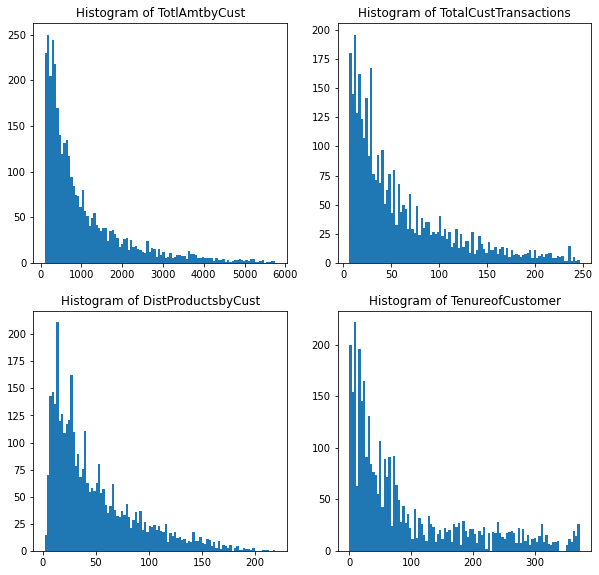

In [28]:
plt.figure(1 , figsize = (10,15))
n = 0 
for x in ['TotlAmtbyCust' , 'TotalCustTransactions' ,'DistProductsbyCust','TenureofCustomer']:
    n += 1
    plt.subplot(3,2,n)
    plt.hist(df_new[x] , bins = 100)
    plt.title('Histogram of {}'.format(x))
plt.show()


Interestingly, the categorical features tell us that the majority of customers are in the UK, purchase products during the weekday and, and interact with the website during normal business hours.

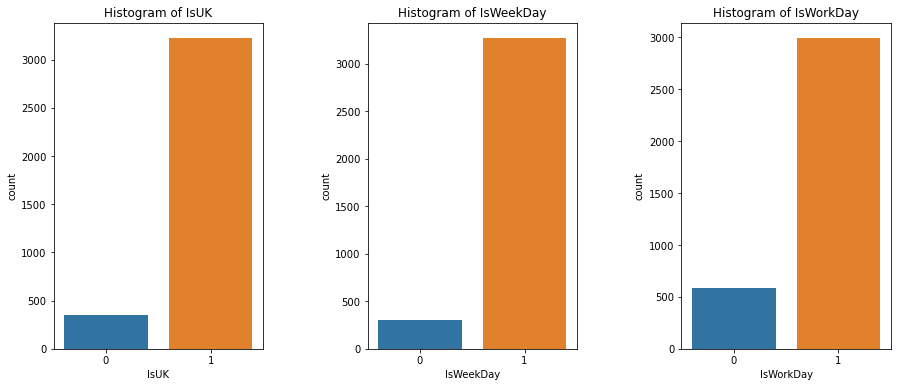

In [29]:
plt.figure(1 , figsize = (15,6))
n = 0 
for x in ['IsUK' , 'IsWeekDay' ,'IsWorkDay']:
    n += 1
    plt.subplot(1,3,n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.countplot(df_new[x] )
    plt.title('Histogram of {}'.format(x))
plt.show()


### Initial Observations

1. Majority of customers have purchased between \\$0-\\$1000 in total from Giftware Shop
1. Majority of customers have purchased between 0-50 or so times
1. Customers tend to only purchase less than 50 distinct products from Giftware Shop in total
1. The tenure is a little bit more spread out - But the majority of Giftware Shop's customer base fall between 0 (new) to 100 days of transactions. This might be a good item to note to Giftware Shop that they should focus on retention of customers.
1. As expected, the majority of the customers are from the UK
1. Most customers purchase products during the week
1. Most customers purchase products during the work day

Since we know that most of the customers are in the UK, let's go ahead and remove anyone outside of the UK as a customer. There's not a ton of data to delineate customers from outside of the UK so let's focus this to reflect only UK customers.

Let's keep customers who purchase during the week & workday for now since they do not appear to have much presence in the dataset

In [30]:
df_new = df_new[(df_new["IsUK"] == 1) ]
df_new.reset_index(drop=True, inplace=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3224 entries, 0 to 3223
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TotlAmtbyCust          3224 non-null   float64
 1   TotalCustTransactions  3224 non-null   int64  
 2   DistProductsbyCust     3224 non-null   int64  
 3   TenureofCustomer       3224 non-null   int64  
 4   IsUK                   3224 non-null   uint8  
 5   IsWeekDay              3224 non-null   uint8  
 6   IsWorkDay              3224 non-null   uint8  
dtypes: float64(1), int64(3), uint8(3)
memory usage: 110.3 KB


Now that we have cleaned our data, let's preprocess our continuous features using StandardScaler

In [31]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(df_new[['TotlAmtbyCust' , 'TotalCustTransactions' ,'DistProductsbyCust','TenureofCustomer']])

## Apply K Means Models to Dataset

Now that we have preprocessed our features, let's now apply KMeans to our dataset.

For Kmeans, let's see where the elbow falls. Although the KElbowVisualizer is not able to detect an elbow outright, we observe that the initial elbow falls around n=3 components. Let's use that in our model.

In [32]:
from sklearn.cluster import KMeans
import sys
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans(random_state=42)

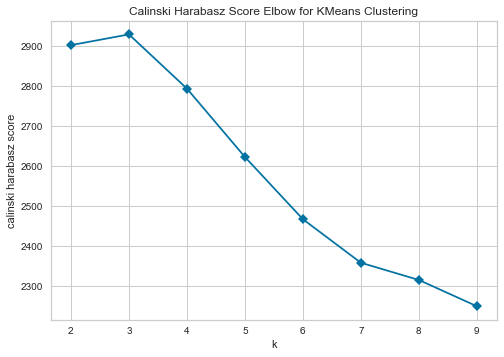

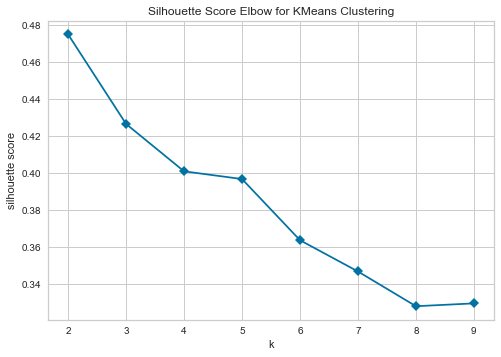

In [33]:
visualizer = KElbowVisualizer(kmeans, k=(2,10), metric = 'calinski_harabasz', timings=False)
visualizer.fit(X_scaled) 
visualizer.show()        
visualizer = KElbowVisualizer(kmeans, k=(2,10), metric = 'silhouette', timings=False,locate_elbow=True)
visualizer.fit(X_scaled)   
visualizer.show()

In [34]:
k_means = KMeans(n_clusters= 3, init='k-means++', random_state=0).fit(X_scaled)
clusters = k_means.predict(X_scaled)

cl_labels_k = k_means.labels_

#### Dimensionality Reduction using PCA

Use PCA to reduce our dimensionality to show cluster visualization on a 2D plane to see how KMeans clusters our data

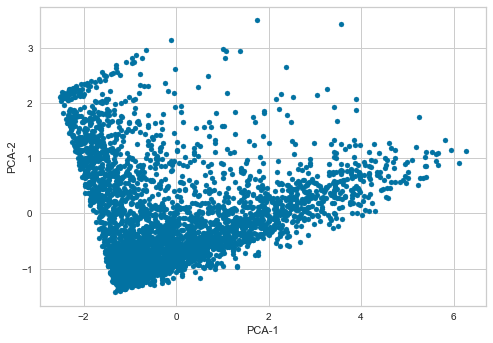

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], s = 25)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

As we look at the data without cluster assignment, it looks like the data is generally a single cluster; one could possibly infer that there are 2 perpedicular clusters but since they are so close together, let's make an inference that the models should detect a single cluster of customers for the most part.

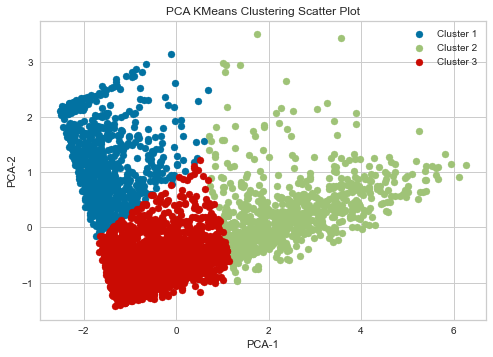

In [36]:
plt.scatter(X_pca[cl_labels_k==0,0],X_pca[cl_labels_k==0,1],label='Cluster 1')
plt.scatter(X_pca[cl_labels_k==1,0],X_pca[cl_labels_k==1,1],label='Cluster 2')
plt.scatter(X_pca[cl_labels_k==2,0],X_pca[cl_labels_k==2,1],label='Cluster 3')

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend()
plt.title('PCA KMeans Clustering Scatter Plot')
plt.savefig('KMEANS.png')

Kmeans grouped our cluster into 3 distinct groups! Right down the middle. 

Now let's join our cluster label back to our original dataset & visualize how our clusters factor into the continuous features. We can observe unique behaviors of each cluster against the features. We will perform this for all 3 models

In [37]:
df_labels = pd.DataFrame(k_means.labels_ , columns = list(['labels']))
df_labels.astype({'labels': 'object'}).dtypes
df_labels.loc[(df_labels.labels == 0)] = 'Cluster 1'
df_labels.loc[(df_labels.labels == 1)] = 'Cluster 2'
df_labels.loc[(df_labels.labels == 2)] = 'Cluster 3'
df_new['Kmeans_labels'] = df_labels['labels'].astype('category')

In [38]:
df_new['Kmeans_labels'].value_counts().sort_index()

Cluster 1     733
Cluster 2     753
Cluster 3    1738
Name: Kmeans_labels, dtype: int64

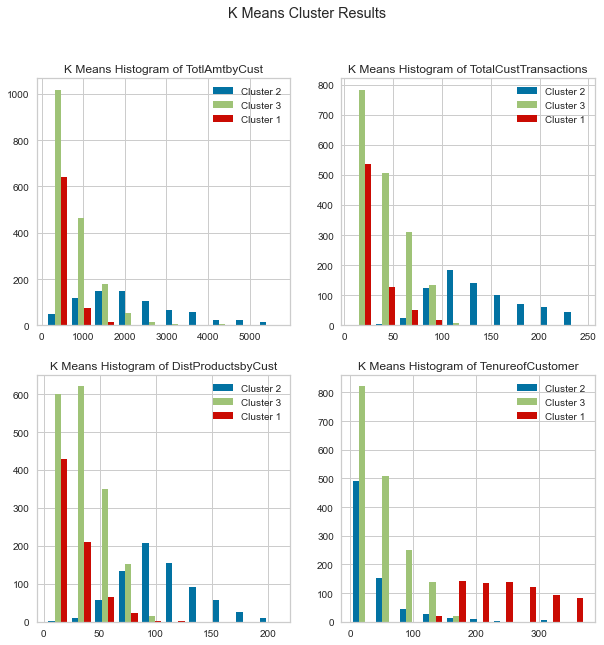

In [39]:
plt.figure(1 , figsize = (10,10))
n = 0 
for var in ['TotlAmtbyCust' , 'TotalCustTransactions' ,'DistProductsbyCust','TenureofCustomer']:
    n += 1
    label = df_new['Kmeans_labels'].unique()                   

    plt.subplot(2,2,n)
    plt.hist([df_new.loc[df_new['Kmeans_labels'] == x, var] for x in label], label=label)

    plt.title('K Means Histogram of {}'.format(var))
    plt.legend()
plt.suptitle('K Means Cluster Results')
plt.savefig('KMEANSHistograms.png')


#### Conclusions on K-Means Clustering with k=3

K-Means Clustering identified 3 primary clusters in the dataset:

- Customers tagged to __Cluster Id 2__ have a high amount of transactions as compared to the other customer clusters.
- Customers tagged to __Cluster Id 2__ are also frequent buyers & tend to buy a wider array of products.
- Customers tagged to __Cluster Id 3__ are newer buyers and, while they buy more than cluster 1, they don't really spend that much from a total amount & transaction perspective.
- Customers tagged to __Cluster Id 1__ are not recent buyers and tend to purchase less (in total amount spent, transactions, as well as the type of products they buy) and hence least of importance from business point of view.

But based on the dimensionality reduction we perform to visualize our clusters, does this really reflect our customer base? It looks like one big cluster, which gives the indication that KMeans isn't do the best job at fitting our model. Let's try DBSCAN & Spectral Clustering to see if they do a better job at identifying our customer segmentation


## Apply DBScan Model to Dataset

Let's now apply DBScan to our preprocessed dataset. Why DBScan? The epsilon parameter helps us better understand 'neighbors' in the dataset; in this case since there is a single cluster, DBSCAN should be preferable to KMeans to solve our customer segmentation problem. 


In [40]:
from sklearn.cluster import DBSCAN
db = DBSCAN().fit(X_scaled)
cl_labels_d = db.labels_

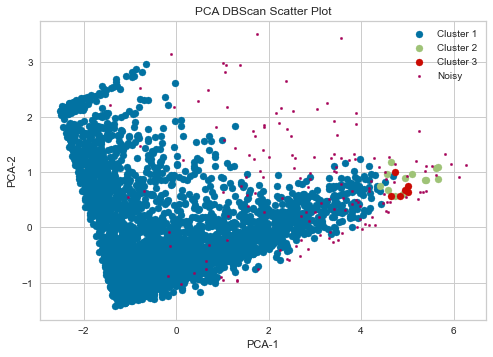

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)
# X_pca_centers_dbscan = pca.transform(cl_centers)

plt.scatter(X_pca[cl_labels_d==0,0],X_pca[cl_labels_d==0,1],label='Cluster 1')
plt.scatter(X_pca[cl_labels_d==1,0],X_pca[cl_labels_d==1,1],label='Cluster 2')
plt.scatter(X_pca[cl_labels_d==2,0],X_pca[cl_labels_d==2,1],label='Cluster 3')
plt.scatter(X_pca[cl_labels_d==-1,0],X_pca[cl_labels_d==-1,1],s=6,label='Noisy')
# plt.scatter(X_pca_centers_kmeans[:, 0], X_pca_centers_kmeans[:, 1], c='black', s = 75)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend()
plt.title('PCA DBScan Scatter Plot')
plt.savefig('DBSCAN.png')

And as we suspected, DBScan got the idea for the most part that there is 1 primary cluster with some outliers & noise mixed in. I think this is our best model out of the 3 but let's check the last one to confirm

In [42]:
df_labels = pd.DataFrame(cl_labels_d, columns = list(['labels']))
df_labels.astype({'labels': 'object'}).dtypes
df_labels.loc[(df_labels.labels == -1)] = 'Noisy'
df_labels.loc[(df_labels.labels == 0)] = 'Cluster 1'
df_labels.loc[(df_labels.labels == 1)] = 'Cluster 2'
df_labels.loc[(df_labels.labels == 2)] = 'Cluster 3'
df_new['DBSCAN_labels'] = df_labels['labels'].astype('category')

In [43]:
df_new['DBSCAN_labels'].value_counts().sort_index()

Cluster 1    3054
Cluster 2      13
Cluster 3       6
Noisy         151
Name: DBSCAN_labels, dtype: int64

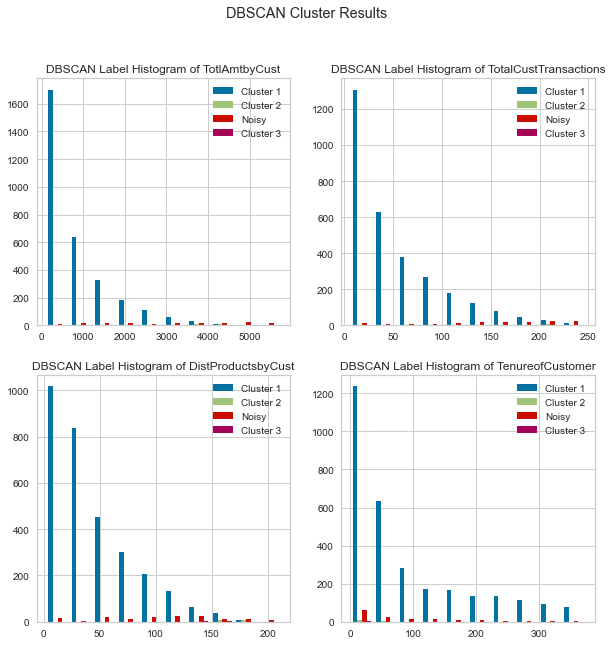

In [44]:
plt.figure(1 , figsize = (10,10))
n = 0 
for var in ['TotlAmtbyCust' , 'TotalCustTransactions' ,'DistProductsbyCust','TenureofCustomer']:
    n += 1
    label = df_new['DBSCAN_labels'].unique()                   

    plt.subplot(2,2,n)
    plt.hist([df_new.loc[df_new['DBSCAN_labels'] == x, var] for x in label], label=label)

    plt.title('DBSCAN Label Histogram of {}'.format(var))
    plt.legend()
plt.suptitle('DBSCAN Cluster Results')
plt.savefig('DBSCANHistograms.png')
plt.show()


#### Conclusions on DBSCAN Clustering

This algorithm looks promising! It was able to identify that the majority of our customers fit in the same cluster based on their behaviors.

DBSCAN Clustering identified 3 primary cluster & 1 noisy label:

- DBSCAN grouped the majority of our customers in __Cluster Id 1__: It recognized that most of the customers spend and transact relatively in the same manner. This aligns with the 'single' cluster presented in the lower dimensionality visualization and that it is known that the majority of its customers are wholesalers.
- Customers tagged to __Cluster Id 2__ & __Cluster Id 3__ did not have a major density in any of the continuous features.
- We can disregard the __Noisy__ label as the algorithm detected noise in our dataset

## Apply Spectral Clustering Model to Dataset

Let's now apply Spectral Clustering to our preprocessed dataset. Why Spectral Clustering? Spectral clustering makes use eigenvalues to detect number of clusters; typically is performs similarly to DBScan but let's see how it does in our model.

For Spectral Clustering, let's use the default parameters with n=3 components

In [45]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3).fit(X_scaled)
cl_labels_s = sc.labels_
np.unique(cl_labels_s)

array([0, 1, 2])

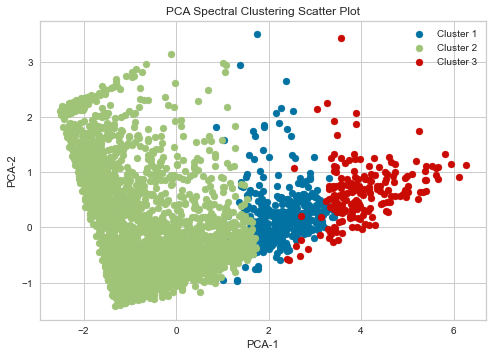

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)
# X_pca_centers_dbscan = pca.transform(cl_centers)

plt.scatter(X_pca[cl_labels_s==0,0],X_pca[cl_labels_s==0,1],label='Cluster 1')
plt.scatter(X_pca[cl_labels_s==1,0],X_pca[cl_labels_s==1,1],label='Cluster 2')
plt.scatter(X_pca[cl_labels_s==2,0],X_pca[cl_labels_s==2,1],label='Cluster 3')
# plt.scatter(X_pca_centers_kmeans[:, 0], X_pca_centers_kmeans[:, 1], c='black', s = 75)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Spectral Clustering Scatter Plot')
plt.legend()
plt.savefig('SPECTRALCLUSTER.png')

Interesting! Spectral Clustering performed in a similar manner to that of KMeans! Spectral Clustering grouped the primary cluster into 3 distinct groups. 

However similar to DBScan, it knew that most of the customers belong to a single cluster. For our dataset, DBScan makes better inference on customer clusters than KMeans & Spectral Clustering.

In [47]:
df_labels = pd.DataFrame(cl_labels_s , columns = list(['labels']))
df_labels.astype({'labels': 'object'}).dtypes
df_labels.loc[(df_labels.labels == 0)] = 'Cluster 1'
df_labels.loc[(df_labels.labels == 1)] = 'Cluster 2'
df_labels.loc[(df_labels.labels == 2)] = 'Cluster 3'
df_new['SpectralClustering_labels'] = df_labels['labels'].astype('category')

In [48]:
df_new['SpectralClustering_labels'].value_counts().sort_index()

Cluster 1     364
Cluster 2    2667
Cluster 3     193
Name: SpectralClustering_labels, dtype: int64

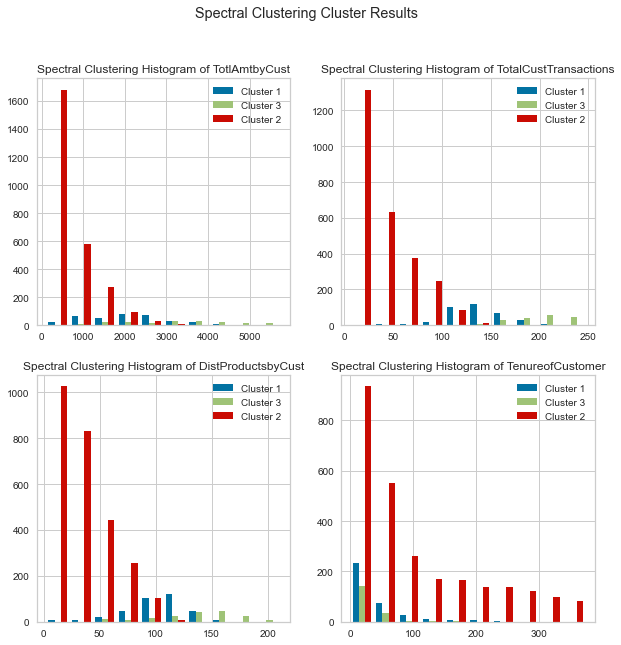

In [49]:
plt.figure(1 , figsize = (10,10))
n = 0 
for var in ['TotlAmtbyCust' , 'TotalCustTransactions' ,'DistProductsbyCust','TenureofCustomer']:
    n += 1
    label = df_new['SpectralClustering_labels'].unique()                   

    plt.subplot(2,2,n)
    plt.hist([df_new.loc[df_new['SpectralClustering_labels'] == x, var] for x in label], label=label)

    plt.title('Spectral Clustering Histogram of {}'.format(var))
    plt.legend()
plt.suptitle('Spectral Clustering Cluster Results')
plt.savefig('SCHistograms.png')


#### Conclusions on Spectral Clustering

Spectral Clustering appears to be the 'middle ground' between KMeans & DBSCAN:
- Similar to DBSCAN, Spectral Clustering identified that majority of customers have similar behaviors and grouped them into a single cluster
- Like KMeans, it still segregated customers into __Cluster 2__ & __Cluster 3__ for those groups that tend to be more frequent buyers & tend to buy a wider array of products. 
- Another interesting observation is __Cluster 1__ tends to have less transactions, product selection, and purchases than that of __Cluster 2__ & __Cluster 3__. Seems like Giftware could really benefit from a marketing campaign to retain its existing clients!

## Final Observations
After we fit our clustering algorithms to our engineered datasets, we can lower the dimensionality of the data onto a 2D plane to get a better understanding of our customer clusters.
<br>
<br>
By applying dimensionality reduction techniques using PCA (note we use PCA <b>AFTER</b> the data is fit to the model so that it does not affect the model's interpretation of the data), we observe that most customers are clustered together, with some trailing noise to the right of the visual. This could possibly be interpreted as two separate perpendicular clusters but in this analysis we will infer that it is one single cluster (for future analysis, we might want to look at other clustering algorithms that can detect perpedicular clusters):
<ul>
<li> We observe that <b>KMeans</b> broke a single cluster into 3 distinct regions, splitting the primary cluster into 3 equal parts;</li> 
<li><b>DBScan</b> understood that most customers belong to a single cluster;</li> 
<li><b>Spectral Clustering</b> identified that most customers belong to a single segment but still broke off the primary cluster into 2 larger groups to the right of the visual. I consider this the 'happy medium' between Kmeans & DBScan where there is still some presence of smaller clusters but not as much as KMeans. </li>
</ul>
   
As we observed, KMeans & Spectral Clustering tried to split the large cluster of customers based on customers who are new, who bought the least products, and who did not make a lot of purchases on the site. DBScan detected that most customers generally have the same spending patterns and lumped most all customers into a single cluster, which aligns to the visuals where we observe one distinct cluster. This also aligns with the general observation that most customers are wholesalers.

We can observe each cluster's behavior against our continuous features, demonstrating how each model interpreted customer segmentation. As stated above, KMeans & Spectral Clustering favored customers who bought a lot from the site & who were newer; DBScan determined that generally the spending patterns of customers are the same, which aligns with the primary customer cluster. DBScan is recommended for further analysis; would like to compare DBScan to other clustering algorithms that can detect clusters that are perpendicular to one another on a 2D plane.

<b>So what's next?</b> While we explored KMeans, I suggest that the marketing team conduct a campaign to draw more attention to the online retail site in general so that they can continue to attract new customers and revenue streams. However, the clusters indicate that existing customer retention could be improved so I recommend an additional campaign that markets to their long term wholesale customers. Perhaps provide discounts for these continued customers so that they come back to purchase again? 

The marketing team is now equipped with information to help drive new campaigns that will hopefully meet their primary customer targets! This way, Giftstore Shop can continue to find new customers while also focusing on current customer retention (since these folks spend a ton!)
